<a href="https://colab.research.google.com/github/kevinhoffmanglyde/oxfordgenaigroup2/blob/main/Group2EndtoEnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section Overview:#
This section is a model comparision for selection of the models.
To use the selected model in the project for the business, we need to be able to feed in a full dataset, retrain the model based on the new data, and create predictions based on the fresh data and newly trained model.
This section separates the Training and Test data for checking accuracy and loss in order to select the better model for the job.
###2024-05-06 - there are some issues with the presentation of charts for comparison.  Also, Prophet is working but requires different names for comparison.  The predictions across the board look like a near perfect match to the Test data.  This is unexpected.  The visualisations are currently wholey unsatisfactory.###


#Mount the Google Drive

In [87]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Authenticate

In [88]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


#Get the data

In [89]:
df = pd.read_csv('gdrive/MyDrive/Product_Store_Sales_Data_with_Category.csv')

#Check the data is there

In [90]:
df.head()

,Date of Sale,Product ID,Store ID,Country,Units Sold,Price Sold,Inflation Rate,GDP Growth Rate,Product Category
0,01/05/2023,1,1,Ireland,29,34.5,8.29,3.8,Mens
1,01/05/2023,1,2,Ireland,16,43.0,8.29,3.8,Mens
2,01/05/2023,1,3,Ireland,22,31.0,8.29,3.8,Mens
3,01/05/2023,1,4,UK,18,28.0,8.29,3.8,Mens
4,01/05/2023,1,5,UK,27,25.5,8.29,3.8,Mens


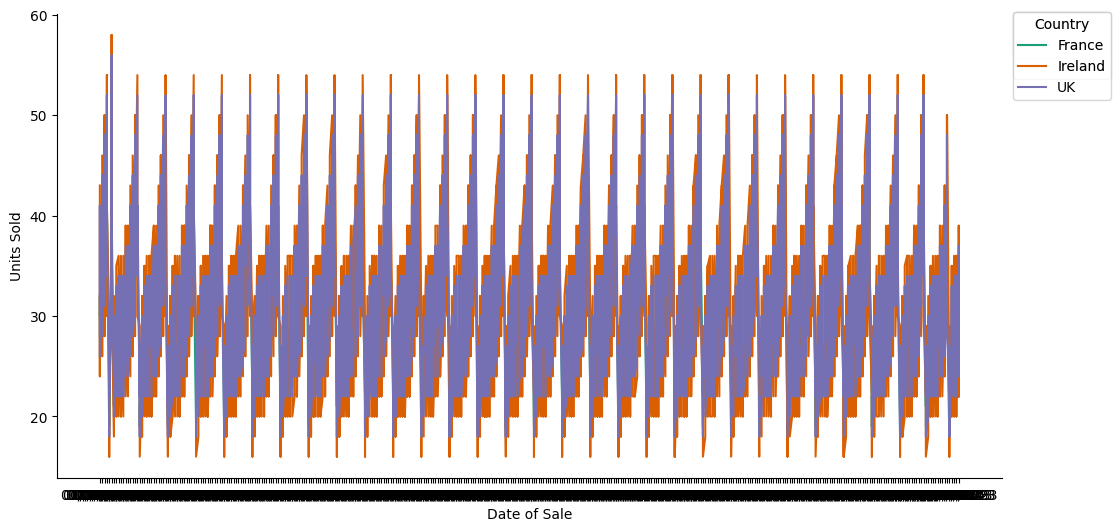

In [91]:
# @title Date of Sale vs Units Sold

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date of Sale']
  ys = series['Units Sold']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date of Sale', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Country')):
  _plot_series(series, series_name, i)
  fig.legend(title='Country', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date of Sale')
_ = plt.ylabel('Units Sold')

<ipython-input-55-d434925d9031>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='Units Sold', y='Country', inner='box', palette='Dark2')


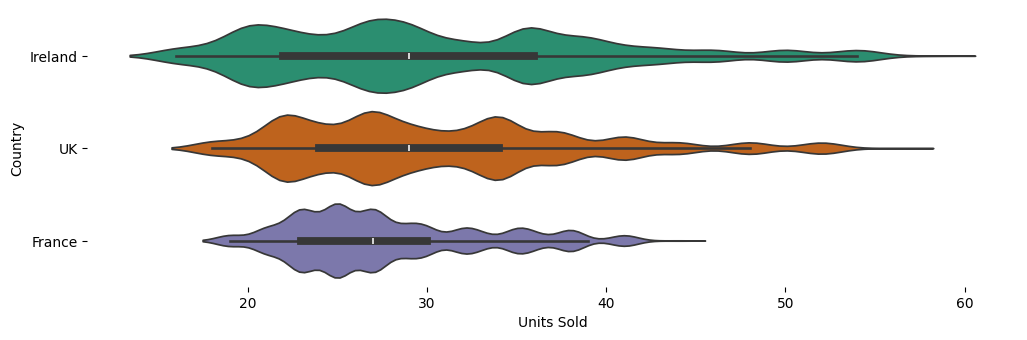

In [55]:
# @title Country vs Units Sold

figsize = (12, 1.2 * len(df['Country'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Units Sold', y='Country', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

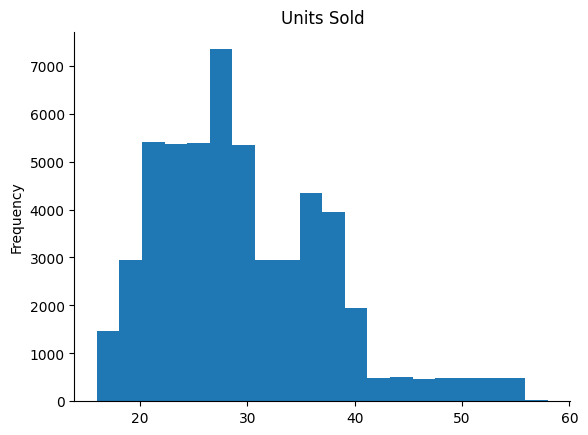

In [56]:
# @title Units Sold

df['Units Sold'].plot(kind='hist', bins=20, title='Units Sold')
plt.gca().spines[['top', 'right',]].set_visible(False)

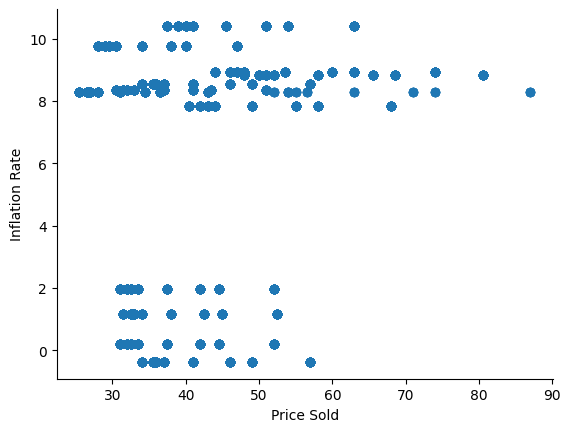

In [57]:
# @title Price Sold vs Inflation Rate
df.plot(kind='scatter', x='Price Sold', y='Inflation Rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

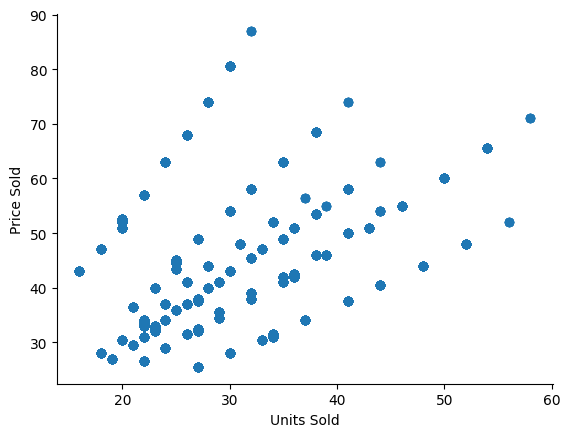

In [58]:
# @title Units Sold vs Price Sold

df.plot(kind='scatter', x='Units Sold', y='Price Sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

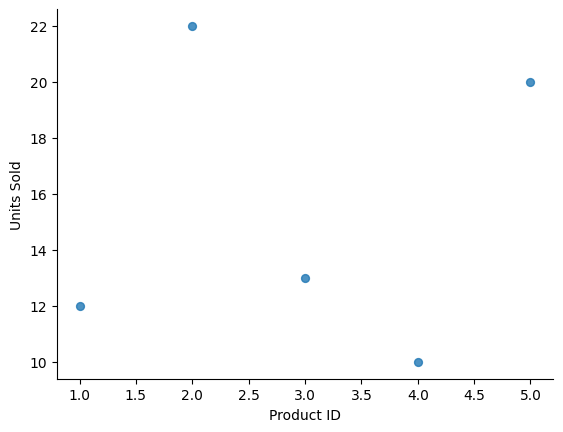

In [59]:
from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Product ID', y='Units Sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

##Now examine the data
The biggest worry is that once we get to the testing of the model, using the synthetic data, we may be trying to map the model based on the training data to data that is completely random.
Since we have data for May 2023 to May 2024 I selected a splitting date of Feb 1st 2024 so we have nearly a 75 to 25% split and are predicting for the latter quarter of the timeframe.
I did not split on the random 80/20 split because we would be including values for the prediction timeframe in the Training set, if I did.

In [93]:
import pandas as pd
import numpy as np
import datetime
datetosplit = 202403
reference_date = datetime.date(1970, 1, 1)
# train_test_split is used to easily divide data into training and testing sets.
from sklearn.model_selection import train_test_split
# LinearRegression is the model we'll be using from scikit-learn.
from sklearn.linear_model import LinearRegression
# mean_absolute_error and mean_squared_error are metrics to evaluate our model.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# matplotlib.pyplot is used for plotting graphs.
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [94]:
df = df.sort_values(["Date of Sale"], ascending = (True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows

,Date of Sale,Product ID,Store ID,Country,Units Sold,Price Sold,Inflation Rate,GDP Growth Rate,Product Category
35280,01/01/2024,1,1,Ireland,43,51.0,10.41,-1.88,Mens
35372,01/01/2024,11,3,Ireland,32,45.5,10.41,-1.88,Womens
35373,01/01/2024,11,4,UK,26,41.0,10.41,-1.88,Womens
35374,01/01/2024,11,5,UK,41,37.5,10.41,-1.88,Womens
35375,01/01/2024,11,6,UK,32,39.0,10.41,-1.88,Womens


In [95]:
df.describe()

,Product ID,Store ID,Units Sold,Price Sold,Inflation Rate,GDP Growth Rate
count,52848.000000,52848.000000,52848.000000,52848.000000,52848.000000,52848.000000
mean,8.500000,5.000000,29.617318,41.940811,6.151035,0.932262
std,4.609816,2.582013,7.736385,11.003209,3.924587,2.206130
min,1.000000,1.000000,16.000000,25.500000,-0.370000,-1.920000
25%,4.750000,3.000000,24.000000,33.000000,1.160000,-1.810000
50%,8.500000,5.000000,27.000000,40.000000,8.290000,2.680000
75%,12.250000,7.000000,35.000000,49.000000,8.940000,3.100000
max,16.000000,9.000000,58.000000,87.000000,10.410000,3.800000


In [96]:
print(df['Units Sold'])

35280    43
35372    32
35373    26
35374    41
35375    32
         ..
35229    24
35228    29
35227    22
35207    27
35279    27
Name: Units Sold, Length: 52848, dtype: int64


In [97]:
df.isnull().sum()

Date of Sale        0
Product ID          0
Store ID            0
Country             0
Units Sold          0
Price Sold          0
Inflation Rate      0
GDP Growth Rate     0
Product Category    0
dtype: int64

Looks like no Nulls, which is expected for our synthetic data.

In [98]:
df['Units Sold'].isna().sum()

0

In [99]:
#clean up any nulls that might come through in real data
df = df.dropna(subset=['Store ID', 'Product ID', 'Units Sold', 'Date of Sale'])

##Check out the distribution of the data

In [100]:
unique_store = df['Store ID'].nunique()
unique_product = df['Product ID'].nunique()
unique_product_cat = df['Product Category'].nunique()
unique_country = df['Country'].nunique()


print("Distinct Stores:", unique_store)
print("Distinct Products:", unique_product)
print("Distinct Product Categories:", unique_product_cat)
print("Distinct Countries:", unique_country)

Distinct Stores: 9
Distinct Products: 16
Distinct Product Categories: 2
Distinct Countries: 3


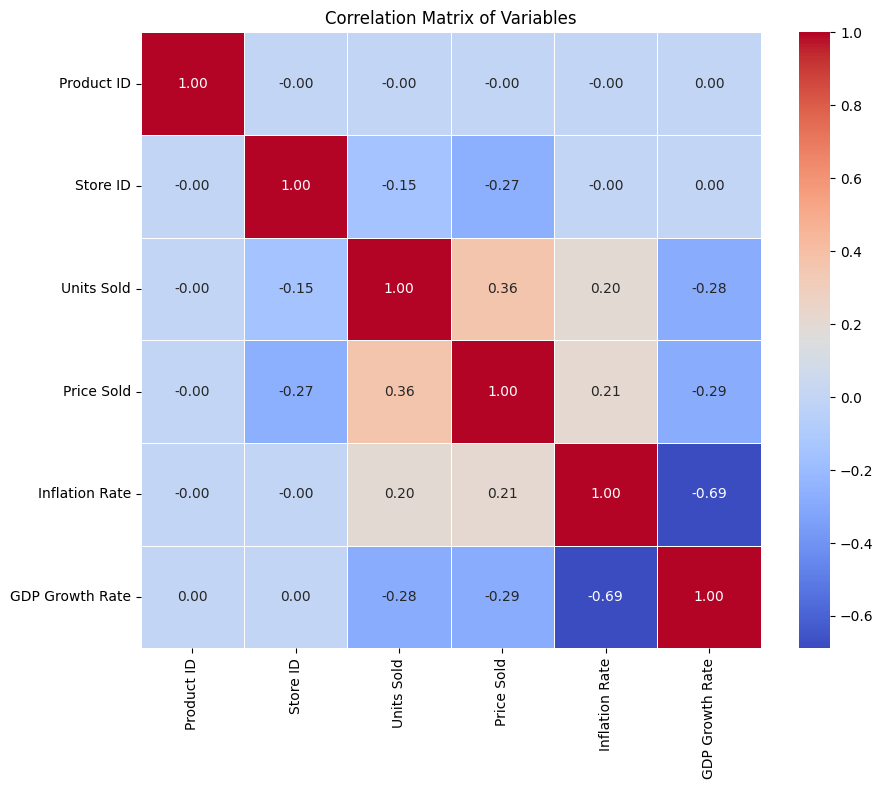

In [101]:
# Calculating the correlation matrix
correlation_matrix = df.corr(numeric_only=True)
#numeric_only is a new variable for the correlation matrix.
#If we want to include Country, we would have to include one-hot-encoding on Country because it is a string and will not fit in a correlation matrix.
# Initializes a new figure for plotting with a specified size to ensure the heatmap is large enough to read.
plt.figure(figsize=(10, 8))

# Creates a heatmap to visualize the correlation matrix.
# - annot=True displays the correlation coefficient values inside the squares.
# - cmap='coolwarm' chooses a color map that visually represents positive (warm) and negative (cool) correlations.
# - fmt=".2f" formats the annotation strings to display only two decimal places.
# - linewidths=.5 adds lines between squares to separate them visually.
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Sets the title of the heatmap for clarity.
plt.title('Correlation Matrix of Variables')

# Displays the plot. Without this, the figure would not be shown in a notebook.
plt.show()

In [102]:
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'], format='%d/%m/%Y')
min_sale_date = df['Date of Sale'].min()
max_sale_date = df['Date of Sale'].max()

print("Minimum date:", min_sale_date)
print("Maximum date:", max_sale_date)

Minimum date: 2023-05-01 00:00:00
Maximum date: 2024-05-01 00:00:00


#Date issues##
Since we are trying to predict future demand, this suggests that when we divide the Training and Test data, we need to do this on a date basis.  Including dates in the training set that should appear in the test set is not desired.  When using this on real data in production, the future dates will all be empty.

So, selecting out test and train data set should probably be on dates rather than simply a percentage.  The suggestion here is that we train 9 months and test against 3 months.

Once the data split is completed, I had to drop the Date of Sale feature because it would not process as a number.  The componensts of the date can be reconstituted for charts at a later point.
The below includes one-hot encoding for the Product Category and Country.

In [103]:
#df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])
print(df['Date of Sale'].head(10))
#df['Units Sold'] = df['Units Sold'].astype(int)
print('Actuals:', df['Units Sold'].head(10))

# find the rows that contain non-integer values
print(df['Units Sold'].head(10))

35280   2024-01-01
35372   2024-01-01
35373   2024-01-01
35374   2024-01-01
35375   2024-01-01
35376   2024-01-01
35377   2024-01-01
35371   2024-01-01
35378   2024-01-01
35380   2024-01-01
Name: Date of Sale, dtype: datetime64[ns]
Actuals: 35280    43
35372    32
35373    26
35374    41
35375    32
35376    28
35377    32
35371    24
35378    30
35380    24
Name: Units Sold, dtype: int64
35280    43
35372    32
35373    26
35374    41
35375    32
35376    28
35377    32
35371    24
35378    30
35380    24
Name: Units Sold, dtype: int64


#Split the data into Past and "Future"

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


In [105]:
print(df['Date of Sale'])

35280   2024-01-01
35372   2024-01-01
35373   2024-01-01
35374   2024-01-01
35375   2024-01-01
           ...    
35229   2023-12-31
35228   2023-12-31
35227   2023-12-31
35207   2023-12-31
35279   2023-12-31
Name: Date of Sale, Length: 52848, dtype: datetime64[ns]


In [106]:

df['YearMonth'] = df['Date of Sale'].dt.year*100+df['Date of Sale'].dt.month
X = df[['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Product Category']]
dfa = df[['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Units Sold', 'Product Category', 'Country']]


# Perform the grouping and sum aggregation, then reset index to turn it back into a DataFrame
units_sold_aggregate = dfa.groupby(['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Product Category', 'Country'])['Units Sold'].sum().reset_index()
#units_sold_aggregate.rename(columns={'Units Sold': 'Units Sold Aggregate'}, inplace=True)

# Merge the aggregated data back on the original DataFrame based on the grouping columns
dfa = dfa.merge(units_sold_aggregate, on=['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Product Category', 'Country'], how='left')

dfa = dfa.drop(columns=['Units Sold_x'])
dfa = dfa.rename(columns={'Units Sold_y': 'Units Sold'})
#dfa = pd.get_dummies(dfa, columns=['Product Category'])
#dfa = pd.get_dummies(dfa, columns=['Country'])
dfa = dfa.reset_index()
#dfa = dfa.drop(columns=['Product Category'])
print(dfa)
# Add the reset Series to the DataFrame:


Y = dfa['Units Sold']


       index  Store ID  GDP Growth Rate  Inflation Rate  Price Sold  \
0          0         1            -1.88           10.41        51.0   
1          1         3            -1.88           10.41        45.5   
2          2         4            -1.88           10.41        41.0   
3          3         5            -1.88           10.41        37.5   
4          4         6            -1.88           10.41        39.0   
...      ...       ...              ...             ...         ...   
52843  52843         4             2.79           -0.37        37.0   
52844  52844         3             2.79           -0.37        41.0   
52845  52845         2             2.79           -0.37        57.0   
52846  52846         9             2.79           -0.37        49.0   
52847  52847         9             2.79           -0.37        49.0   

       Product ID  YearMonth Product Category  Country  Units Sold  
0               1     202401             Mens  Ireland        1333  
1        

In [132]:
X = dfa.drop(columns='Units Sold')
X = X.drop(columns='GDP Growth Rate')
X = X.drop(columns='Country')
X = X.drop(columns='Product Category')
X = X.drop(columns='Inflation Rate')

In [133]:
X.describe()

,index,Store ID,Price Sold,Product ID,YearMonth
count,52848.00000,52848.000000,52848.000000,52848.000000,52848.000000
mean,26423.50000,5.000000,41.940811,8.500000,202339.752044
std,15256.04785,2.582013,11.003209,4.609816,44.335361
min,0.00000,1.000000,25.500000,1.000000,202305.000000
25%,13211.75000,3.000000,33.000000,4.750000,202307.000000
50%,26423.50000,5.000000,40.000000,8.500000,202310.000000
75%,39635.25000,7.000000,49.000000,12.250000,202401.000000
max,52847.00000,9.000000,87.000000,16.000000,202405.000000


In [134]:
#X = dfa.drop(columns='Country')
print(X.head())

   index  Store ID  Price Sold  Product ID  YearMonth
0      0         1        51.0           1     202401
1      1         3        45.5          11     202401
2      2         4        41.0          11     202401
3      3         5        37.5          11     202401
4      4         6        39.0          11     202401


In [135]:
#split_date = pd.to_datetime(datetosplit)
# Data before the split date
datetosplit = 202403
X_Train = X[X['YearMonth'] < datetosplit]
X_Test = X[X['YearMonth'] >= datetosplit]
Y_Train = Y[df['YearMonth'] < datetosplit]
Y_Test = Y[df['YearMonth'] >= datetosplit]

#X_Train = X_Train.drop(columns=['Date of Sale'])

#X_Test = X_Test.drop(columns=['Date of Sale'])
#scaler = StandardScaler()
Y_Train = Y_Train.drop(columns=['YearMonth'])
Y_Test = Y_Test.drop(columns=['YearMonth'])
print("Data before the split date:")
print(X_Train)

print("Data on or after the split date:")
print(X_Test)

print("Data before the split date:")
print(Y_Train)

print("Data on or after the split date:")
print(Y_Test)

Data before the split date:
       index  Store ID  Price Sold  Product ID  YearMonth
0          0         1        51.0           1     202401
1          1         3        45.5          11     202401
2          2         4        41.0          11     202401
3          3         5        37.5          11     202401
4          4         6        39.0          11     202401
...      ...       ...         ...         ...        ...
52843  52843         4        37.0          11     202312
52844  52844         3        41.0          11     202312
52845  52845         2        57.0          11     202312
52846  52846         9        49.0           8     202312
52847  52847         9        49.0          16     202312

[43920 rows x 5 columns]
Data on or after the split date:
       index  Store ID  Price Sold  Product ID  YearMonth
288      288         3        53.5          11     202403
289      289         4        48.0          11     202403
290      290         5        44.0         

#Linear Regression model

In [136]:
# Creating an instance of the LinearRegression model.
modelLR = LinearRegression()

# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelLR.fit(X_Train, Y_Train)


LinearRegression()

In [137]:
# Cross-validating the model
scores = cross_val_score(modelLR, X_Train, Y_Train, cv=3)
print(f"Cross-validated R² scores: {scores}")
print(f"Average R² score: {np.mean(scores)}")

Cross-validated R² scores: [-0.00300111 -0.00226128 -0.00133251]
Average R² score: -0.0021982977242992106


In [138]:
# Use the trained model to make predictions on the testing set.
predictionsLR = modelLR.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.

# Evaluating the model
mse = mean_squared_error(Y_Test, predictionsLR)
r2 = r2_score(Y_Test, predictionsLR)
print('MAE:', mean_absolute_error(Y_Test, predictionsLR))
print('MSE:', mean_squared_error(Y_Test, predictionsLR))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsLR)))
print(f"R² score: {r2}")

MAE: 180.67944498293457
MSE: 50743.901832847514
RMSE: 225.26407133150974
R² score: -0.0016046271490710584


In [139]:
X_Test.describe()

,index,Store ID,Price Sold,Product ID,YearMonth
count,8928.000000,8928.000000,8928.000000,8928.00000,8928.000000
mean,25647.758065,5.000000,55.910394,8.50000,202403.516129
std,15418.561865,2.582134,10.354879,4.61003,0.531065
min,288.000000,1.000000,44.000000,1.00000,202403.000000
25%,12599.750000,3.000000,48.000000,4.75000,202403.000000
50%,25631.500000,5.000000,52.000000,8.50000,202403.500000
75%,38663.250000,7.000000,63.000000,12.25000,202404.000000
max,52127.000000,9.000000,87.000000,16.00000,202405.000000


#Charts#
I'm fairly sure I made an error somewhwere in here because it seems that the predicted values and actual values are the same according to the chart.  According the the MAE this is not the case.
I printed out the values for prediction and test, and the results were a match for what values I could see.

In [140]:
from datetime import datetime
#X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
X_Test.reset_index(drop=True, inplace=True)
Y_Test.reset_index(drop=True, inplace=True)
merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
print(merged_df)
merged_df.describe()


      index  Store ID  Price Sold  Product ID  YearMonth  Units Sold
0       288         3        53.5          11     202403         899
1       289         4        48.0          11     202403         682
2       290         5        44.0          11     202403         837
3       291         6        46.0          11     202403         558
4       292         7        47.0          11     202403         682
...     ...       ...         ...         ...        ...         ...
8923  52123         7        47.0          11     202403         744
8924  52124         6        46.0          11     202403         899
8925  52125         5        44.0          11     202403         682
8926  52126         4        48.0          11     202403         837
8927  52127         1        60.0          12     202403         837

[8928 rows x 6 columns]


,index,Store ID,Price Sold,Product ID,YearMonth,Units Sold
count,8928.000000,8928.000000,8928.000000,8928.00000,8928.000000,8928.000000
mean,25647.758065,5.000000,55.910394,8.50000,202403.516129,886.258065
std,15418.561865,2.582134,10.354879,4.61003,0.531065,225.096163
min,288.000000,1.000000,44.000000,1.00000,202403.000000,496.000000
25%,12599.750000,3.000000,48.000000,4.75000,202403.000000,713.000000
50%,25631.500000,5.000000,52.000000,8.50000,202403.500000,837.000000
75%,38663.250000,7.000000,63.000000,12.25000,202404.000000,1023.000000
max,52127.000000,9.000000,87.000000,16.00000,202405.000000,1620.000000


In [141]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
print(merged_df2)

      index  Store ID  Price Sold  Product ID  YearMonth  Prediction
0       288         3        53.5          11     202403  886.642550
1       289         4        48.0          11     202403  888.089812
2       290         5        44.0          11     202403  889.136185
3       291         6        46.0          11     202403  888.579005
4       292         7        47.0          11     202403  888.289084
...     ...       ...         ...         ...        ...         ...
8923  52123         7        47.0          11     202403  909.231578
8924  52124         6        46.0          11     202403  909.522307
8925  52125         5        44.0          11     202403  910.080295
8926  52126         4        48.0          11     202403  909.034730
8927  52127         1        60.0          12     202403  905.810690

[8928 rows x 6 columns]


      index  Store ID  Price Sold  Product ID  YearMonth  Units Sold
0       288         3        53.5          11     202403         899
1       289         4        48.0          11     202403         682
2       290         5        44.0          11     202403         837
3       291         6        46.0          11     202403         558
4       292         7        47.0          11     202403         682
...     ...       ...         ...         ...        ...         ...
8923  52123         7        47.0          11     202403         744
8924  52124         6        46.0          11     202403         899
8925  52125         5        44.0          11     202403         682
8926  52126         4        48.0          11     202403         837
8927  52127         1        60.0          12     202403         837

[8928 rows x 6 columns]


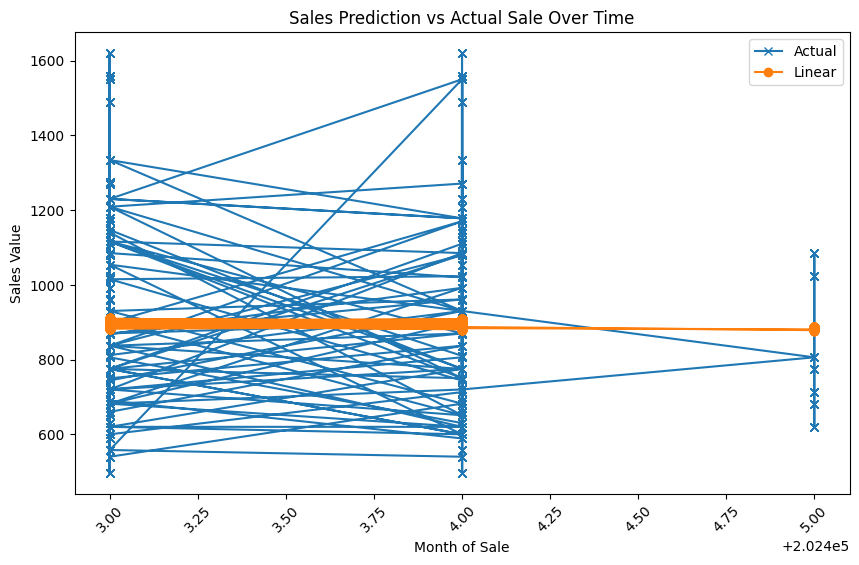

In [147]:
print(merged_df)
#print(filtered_df2)
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
#print(filtered_df)
plt.plot(merged_df['YearMonth'] , merged_df['Units Sold'], label='Actual', marker='x')  # Plot Sales Prediction
plt.plot(merged_df2['YearMonth'] ,  merged_df2['Prediction'], label='Linear', marker='o')  # Plot Sales Prediction
# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Month of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability
#plt.ylim(0, 150)

# Adding legend
plt.legend()

# Show the plot
plt.show()
#X_Test = X_Test.drop(columns=['Date of Sale'])

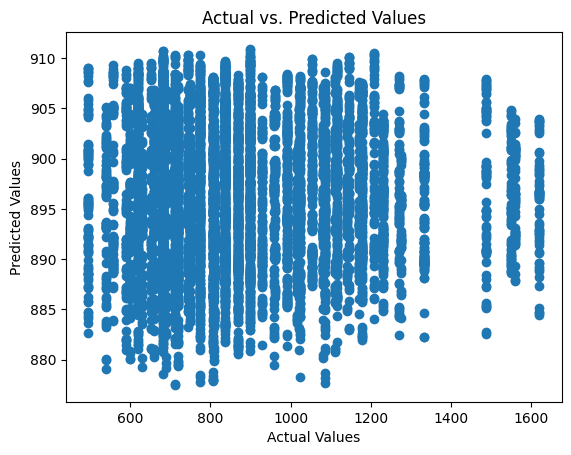

In [148]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsLR)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Random Forest

In [ ]:
# Creating an instance of the LinearRegression model.
modelRF = RandomForestRegressor(n_estimators=100)

# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelRF.fit(X_Train, Y_Train)

RandomForestRegressor()

In [ ]:
# Use the trained model to make predictions on the testing set.
predictionsRF = modelRF.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.
# Evaluating the model
mseRF = mean_squared_error(Y_Test, predictionsRF)
r2RF = r2_score(Y_Test, predictionsRF)
print('MAE:', mean_absolute_error(Y_Test, predictionsRF))
print('MSE:', mean_squared_error(Y_Test, predictionsRF))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsRF)))
print(f"R² score: {r2RF}")

MAE: 25.693355434782607
MSE: 915.5769701992753
RMSE: 30.25850244475551
R² score: -0.05859941286211012


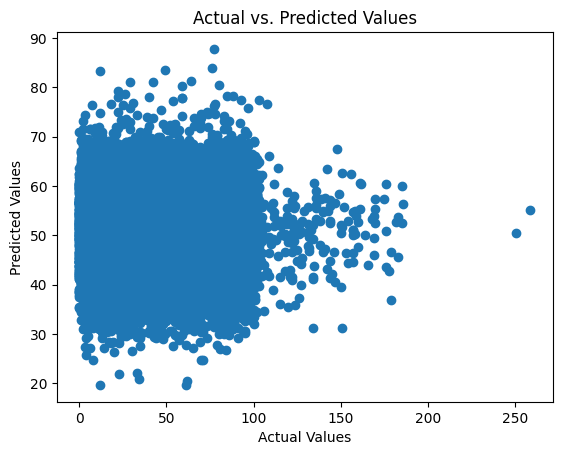

In [ ]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsRF)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Prophet

In [ ]:
pip install pystan


In [ ]:
#pip install fbprophet


In [ ]:
#pip install --upgrade numpy pandas

In [ ]:
pip install prophet


In [ ]:
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
#this has all of the records without the split
dfpt = df
dfpt.rename(columns={'Date of Sale': 'ds', 'Units Sold': 'y'}, inplace=True)
dftrain = dfpt[dfpt['ds'] < split_date]
dftest = dfpt[dfpt['ds'] >= split_date]
modelPT = Prophet(yearly_seasonality=True)
modelPT.fit(dftrain)

NameError: name 'split_date' is not defined

In [ ]:
#need to do the split on this to get the future
#future = modelPT.make_future_dataframe(periods=len(dftest), freq='D')
#forecast = modelPT.predict(future)

In [ ]:
#Not sure how valid this is for for Prophet
#print('MAE:', mean_absolute_error(Y_Test, forecast))
#print('MSE:', mean_squared_error(Y_Test, forecast))
#print('RMSE:', np.sqrt(mean_squared_error(Y_Test, forecast)))

In [ ]:
# Plotting actual vs predicted values to visualize how well our model is performing.
#plt.scatter(future['ds'], forecast)
#plt.xlabel('Actual Values')  # X-axis label
#plt.ylabel('Predicted Values')  # Y-axis label
#plt.title('Actual vs. Predicted Values')  # Graph title
#plt.show()  # Display the plot

#Gradient Booster

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
modelGB = GradientBoostingRegressor(random_state=42)
modelGB.fit(X_Train, Y_Train)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Predictions
predGB = modelGB.predict(X_Test)

In [ ]:
# Evaluation
mae = mean_absolute_error(Y_Test, predGB)
mse = mean_squared_error(Y_Test, predGB)
r2 = r2_score(Y_Test, predGB)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Absolute Error: 25.160700722022238
Mean Squared Error: 865.7677695015909
R² Score: -0.0010095079934639983


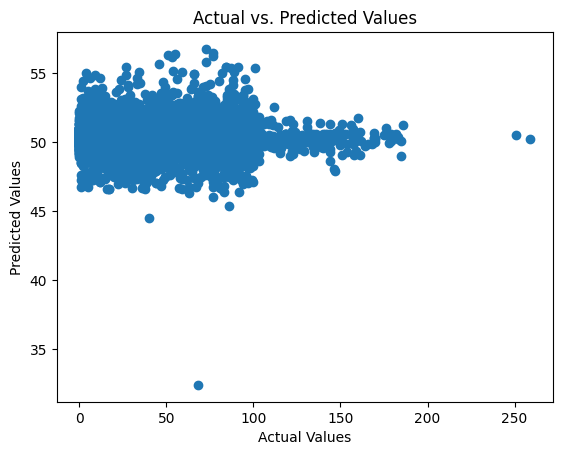

In [ ]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predGB)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Long Term Short Memory

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
# Normalize features
scaler = MinMaxScaler()
target = X_Train['Units Sold'].values.reshape(-1,1)
features_scaled = scaler.fit_transform(X_Train)
target_scaled = scaler.fit_transform(target)

KeyError: 'Units Sold'

In [ ]:
# Data preparation for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 1
X, y = create_dataset(features_scaled, target_scaled, time_steps)

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Problem here is the fact that dates from the forecast period are likely to be in the Training data
#may be able to use the X_Train and X_Test values instead

In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Fit model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

In [ ]:
# Predict and evaluate
predictionLSTM = model.predict(X_test)
mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(predictionLSTM))
print(f'Mean Squared Error: {mse}')

In [ ]:
print(Y_Test)
print()
print(predictionLSTM)

In [ ]:
# Create the plot
from datetime import datetime
X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
print(X_Test['Date of Sale'].head(10))

merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
filtered_df = merged_df[merged_df['Store ID'] == 10100]
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predGB, columns=['PredictionGB'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
filtered_df2 = merged_df2[merged_df2['Store ID'] == 10100]
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
filtered_df3 = merged_df3[merged_df3['Store ID'] == 10100]
merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)
filtered_df4 = merged_df4[merged_df4['Store ID'] == 10100]


#X_Test['Date of Sale'] = pd.to_datetime(str(X_Test['Year']) + '-' + str(X_Test['Month']) + '-' + str(X_Test['Day']))
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
plt.plot(filtered_df['Date of Sale'] , filtered_df['Units Sold_y'], label='Actual Value', marker='o')  # Plot Sales Prediction
plt.plot(filtered_df2['Date of Sale'] , filtered_df2['Prediction'], label='Linear', marker='x')  # Plot Sales Prediction
plt.plot(filtered_df3['Date of Sale'] , filtered_df3['PredictionRF'], label='Random Forest', marker='v')  # Plot Sales Prediction
plt.plot(filtered_df4['Date of Sale'] , filtered_df4['PredictionGB'], label='Gradient Booster', marker='^')  # Plot Sales Prediction
#plt.plot(X_Test['Month'] , predictionLSTM, label='Long Term Short Memory', marker='x')  # Plot Sales Prediction

# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time - Store 10100')
plt.xlabel('Date of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predGB, columns=['PredictionGB'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
merged_df2['Model'] = 'Linear Regression'
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
merged_df3['Model'] = 'Random Forest'
merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)
merged_df3['Model'] = 'Gradient Boost'


# Merge all prediction DataFrames into one DataFrame
predictions_df = pd.concat([df_1d, df_1d2, df_1d3], axis=1)

# Merge X_Test with Y_Test
merged_df1 = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
merged_df1['Model'] = 'Actual'
# Now merge this with the combined predictions DataFrame
final_merged_df = pd.merge(merged_df1, predictions_df, left_index=True, right_index=True)

# If you need to display the final DataFrame
print(final_merged_df.head())

   index  Store ID  GDP Growth Rate  Inflation Rate  Price Sold  Product ID  \
0    600         8              0.3             3.4       26.83          10   
1    601        11              0.2             3.1       26.84           3   
2    602        11              0.2             3.1       36.51           2   
3    603        11              0.2             3.1       27.75           1   
4    604        10              0.2             3.1       39.25          20   

   YearMonth  Category_Mens  Category_Womens  Country_France  Country_Germany  \
0     202403           True            False            True            False   
1     202403           True            False           False             True   
2     202403           True            False           False             True   
3     202403           True            False           False             True   
4     202403          False             True           False             True   

   Country_Ireland  Country_Spain  Cou

#Save the DataFrames to CSV for access by Power BI

In [ ]:
# Assuming 'filtered_df' is your DataFrame
final_merged_df.to_csv('gdrive/MyDrive/final_merged_df.csv', index=False)

#Future Steps
For this to be used in the business:
We need to be able to feed in new data and train on that data.  That would be the new Training set.
We then calculate a forecast for the next time period based on the new Training set.

Merge the Dataframes into a larger dataframe
Save that DataFrame into a CSV file in Google Drive
The new file will be accessed by Power BI for additional visualisations.